# Yinelemeli Sinir Ağları (Recurrent Neural Network)(RNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.datasets import imdb # Veri Seti
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding , SimpleRNN , Dense , Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report , roc_curve , auc

import kerastuner as kt
from kerastuner import RandomSearch

import warnings
warnings.filterwarnings("ignore")

C:\Users\emirh\AppData\Local\Temp\ipykernel_16380\2507557446.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


### 1)Veri Setinin Yüklenmesi
imdb 50000 (0 => Olumsuz , 1 => Olumlu)

In [2]:
(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=10000) # num_words : En çok kullanılan 10000 kelime 

### 2)Veri Ön İşleme

Yorumları aynı uzunluğa getirmek için padding yöntemi kullanımı.

In [3]:
maxlen = 100
x_train = pad_sequences(x_train,maxlen=maxlen) # train verisi uzunluğunu ayarla
x_test = pad_sequences(x_test,maxlen=maxlen) #test verisi uzunluğu ayarla

### 3)Modelin Oluşturulması

In [4]:
#hp : hyperparameter
def build_model(hp):
    model = Sequential()
    #Embedding Katmanı : Kelimeleri vektörlere çevirir (Vektör Boyutları : (32,64,96,128))
    model.add(Embedding(input_dim=10000 , output_dim=hp.Int("embedding_output",min_value=32 , max_value = 128 , step=32 ),input_length = maxlen))
    #Simle RNN : RNN katmanı (RNN Hücre Sayısı : (32,64,96,128))
    model.add(SimpleRNN(units=hp.Int("rnn_units",min_value=32,max_value=128,step=32)))
    #Dropout katmanı : Overfitting engellemek için rastgele bazı cel'leri kapatma işlemi
    model.add(Dropout(rate=hp.Float("dropout_rate",min_value=0.2,max_value=0.5,step=0.1)))
    #Çıktı Katmanı 1 cell ve sigmoid (Sigmoid Activation :İkili sınıflandırma için kullanılır . (Çıktı 0 ya da 1 arasında olur.) ) 
    model.add(Dense(1,activation="sigmoid"))
    #Modelin Compile Edilmesi
    model.compile(optimizer=hp.Choice("optimizer",["adam","rmsprop"]),loss="binary_crossentropy",metrics=["accuracy","AUC"])
    return model

### 4)Hiper Parametrelerin Belirlenmesi

In [5]:
# build_model : optimize edilecek model fonk.
#objective : "val_loss" # val_loss en düşük olan en iyisidir , val_accuracy yüksek olan iyidir.
#max_trials : Denenecek model sayısı .
#executions_per_trial : Her model için eğitim denemesi sayısı.
#directory : Modelin kayıt edileceği dizin
#project_name : Proje Adı
tuner = RandomSearch(build_model,objective="val_loss",max_trials = 2, executions_per_trial = 1,directory = "rnn_tuner_directory" ,project_name="imdb_rnn")

Reloading Tuner from rnn_tuner_directory\imdb_rnn\tuner0.json


Ezberleme (Overfitting) engellemek için erken durdurma işlemi (early stopping)

In [6]:
#patience : 3 epoch boyunca val_loss azalmazsa eğitim durdurulmasını sağlar.
#restore_best_weights : En iyi ağirlikların yüklenmesi işlemi.
early_stopping =  EarlyStopping(monitor="val_loss",patience = 3, restore_best_weights=True)

### 5)Model Eğitimi

In [7]:
#validation_split : %20 si validation olarak alınacak .
# x_train,y_train,batch_size=256,epochs=30,validation_split=0.2
tuner.search(x_train , y_train , batch_size=256 , epochs = 30 , validation_split = 0.2 , callbacks = [early_stopping] )

### 6)Modelin Test Edilmesi

In [8]:
best_model = tuner.get_best_models(num_models=1)[0] # En iyi performans gösteren model

In [9]:
loss , accuracy , auc_score = best_model.evaluate(x_test,y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9118 - accuracy: 0.8318 - loss: 0.3853


Tahmin yapma ve modelin performansının değerlendirilmesi

In [10]:
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5 ).astype("int32")
result = classification_report(y_test,y_pred)
print(result)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

           0       0.86      0.79      0.83     12500
           1       0.81      0.87      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



### 7)Roc Eğrisi Hesaplama

In [11]:
fpr , tpr , _ = roc_curve(y_test,y_pred_prob) # Roc eğrisi için fpr (false positive rate) ve tpr (true positive rate) hesaplama 
roc_auc = auc(fpr,tpr) # Roc eğrisi altında kalan alan hesaplanır . 

### 8)Roc Eğrisi Görselleştirme

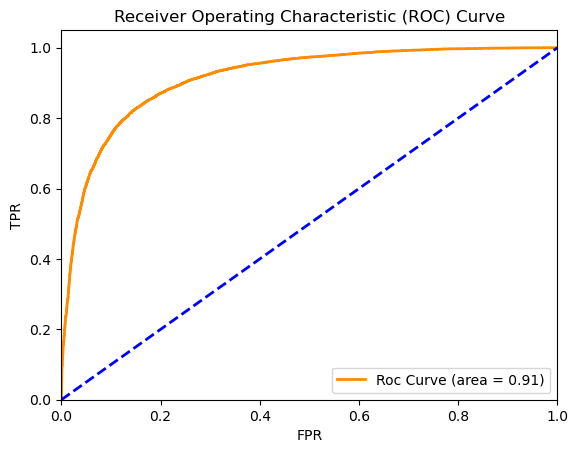

In [12]:
plt.figure()
plt.plot(fpr , tpr , color = "darkorange" , lw = 2 , label = "Roc Curve (area = %0.2f)"%roc_auc)
plt.plot([0,1] , [0,1] , color = "blue" , lw = 2 , linestyle = "--") # Rastgele tahmin çizgisi
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()